In [1]:
import os
from pathlib import Path
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cpu')

In [2]:
import random
import io
import contextlib
import cv2

In [3]:
from yolort.data import COCODetectionDataModule
from yolort.models.transform import YOLOTransform
from yolort.utils.image_utils import (
    color_list,
    plot_one_box,
    cv2_imshow,
    load_names,
    parse_single_image,
    parse_images,
)

In [4]:
# Get label names and COLORS list
import requests

LABELS = []
response = requests.get(
    "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/notebooks/assets/coco.names")
names = response.text

for label in names.strip().split('\n'):
    LABELS.append(label)

COLORS = color_list()

The labels can also be obtained by

```python
LABELS = load_names('../notebooks/assets/coco.names')
```

## Setup the coco128 dataset and dataloader for testing

In [5]:
# Acquire the images and labels from the coco128 dataset
data_path = Path('data-bin')
coco128_dirname = 'coco128'
coco128_path = data_path / coco128_dirname
image_root = coco128_path / 'images' / 'train2017'
annotation_path = coco128_path / 'annotations'

batch_size = 8

In [6]:
with contextlib.redirect_stdout(io.StringIO()):
    datamodule = COCODetectionDataModule(image_root, annotations_path=annotation_path)

In [7]:
test_dataloader = iter(datamodule.train_dataloader(batch_size=batch_size))

## Sample images and targets

In [8]:
images, annotations = next(test_dataloader)

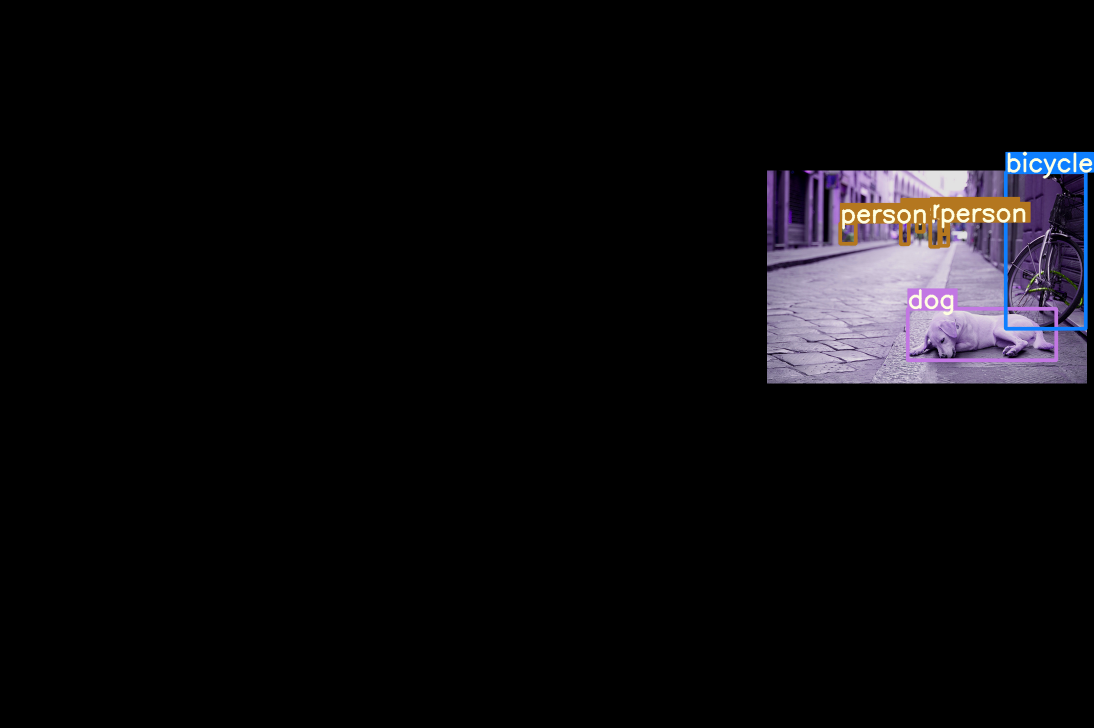

In [9]:
idx = random.randrange(batch_size)
img_raw = cv2.cvtColor(parse_single_image(images[idx]), cv2.COLOR_RGB2BGR)  # For visualization

for box, label in zip(annotations[idx]['boxes'].tolist(), annotations[idx]['labels'].tolist()):
    img_raw = plot_one_box(box, img_raw, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_raw, imshow_scale=0.5)

## Training Batch in Pipeline

In [10]:
size = (640, 640)

In [11]:
transform = YOLOTransform(min(size), max(size), fixed_size=size)

In [12]:
samples, targets = transform(images, annotations)

In [13]:
inputs = parse_images(samples.tensors)

In [14]:
attach_idx = torch.where(targets[:, 0].to(dtype=torch.int32) == idx)[0]

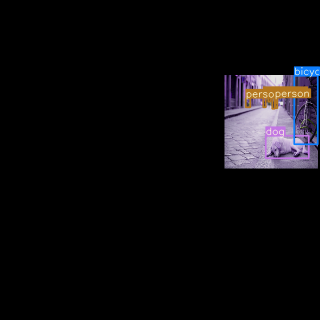

In [15]:
img_training = cv2.cvtColor(inputs[idx], cv2.COLOR_RGB2BGR)  # For visualization
targets_training = targets[attach_idx]
for box, label in zip(targets_training[:, 2:].tolist(), targets[attach_idx][:, 1].tolist()):
    label = int(label)
    img_training = plot_one_box(box, img_training, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_training, imshow_scale=0.5)

### Extractor Intermediate Feature

In [16]:
from yolort.models.yolo import yolov5_darknet_pan_s_r40 as yolov5s
from yolort.utils import FeatureExtractor

In [17]:
model = yolov5s()
model = model.train()

In [18]:
yolo_features = FeatureExtractor(model, return_layers=['backbone', 'head'])

In [19]:
intermediate_features = yolo_features(samples.tensors, targets)

In [20]:
features = intermediate_features['backbone']

In [21]:
head_outputs = intermediate_features['head']

In [22]:
[f.shape for f in head_outputs]

[torch.Size([8, 3, 80, 80, 85]),
 torch.Size([8, 3, 40, 40, 85]),
 torch.Size([8, 3, 20, 20, 85])]

In [23]:
[f.shape for f in features]

[torch.Size([8, 128, 80, 80]),
 torch.Size([8, 256, 40, 40]),
 torch.Size([8, 512, 20, 20])]

In [24]:
assert False

AssertionError: 

### Select Training Samples

In [ ]:
num_layers = len(head_outputs)
anchors = torch.as_tensor(anchor_grids, dtype=torch.float32, device=device)
strides = torch.as_tensor(strides, dtype=torch.float32, device=device)
anchors = anchors.view(num_layers, -1, 2) / strides.view(-1, 1, 1)

### Assign Targets to Anchors

In [ ]:
# Build targets for compute_loss(), input targets(image,class,x,y,w,h)
num_anchors = len(anchor_grids)  # number of anchors
num_targets = len(targets)  # number of targets

targets_cls, targets_box, anchors_encode = [], [], []
indices = []
grid_assigner = []  # Anchor Visulization
gain = torch.ones(7, device=device)  # normalized to gridspace gain
# same as .repeat_interleave(num_targets)
ai = torch.arange(num_anchors, device=device).float().view(num_anchors, 1).repeat(1, num_targets)
targets = torch.cat((targets.repeat(num_anchors, 1, 1), ai[:, :, None]), 2)  # append anchor indices

g = 0.5  # bias
off = torch.tensor([[0, 0],
                    [1, 0], [0, 1], [-1, 0], [0, -1],  # j,k,l,m
                    # [1, 1], [1, -1], [-1, 1], [-1, -1],  # jk,jm,lk,lm
                    ], device=device).float() * g  # offsets

In [ ]:
anchor_threshold = 5000

In [ ]:
for i in range(num_layers):
    anchors_per_layer = anchors[i]
    gain[2:6] = torch.tensor(head_outputs[i].shape)[[3, 2, 3, 2]]  # xyxy gain

    # Match targets to anchors
    targets_with_gain = targets * gain
    if num_targets:
        # Matches
        ratios_wh = targets_with_gain[:, :, 4:6] / anchors_per_layer[:, None]  # wh ratio
        ratios_filtering = torch.max(ratios_wh, 1. / ratios_wh).max(2)[0]
        inds = torch.where(ratios_filtering < anchor_threshold)
        targets_with_gain = targets_with_gain[inds]  # filter

        # Offsets
        grid_xy = targets_with_gain[:, 2:4]  # grid xy
        grid_xy_inverse = gain[[2, 3]] - grid_xy  # inverse
        inds_jk = (grid_xy % 1. < g) & (grid_xy > 1.)
        inds_lm = (grid_xy_inverse % 1. < g) & (grid_xy_inverse > 1.)
        inds_ones = torch.ones_like(inds_jk[:, 0])[:, None]
        inds = torch.cat((inds_ones, inds_jk, inds_lm), dim=1).T
        targets_with_gain = targets_with_gain.repeat((5, 1, 1))[inds]
        offsets = (torch.zeros_like(grid_xy)[None] + off[:, None])[inds]
    else:
        targets_with_gain = targets[0]
        offsets = torch.tensor(0, device=device)

    # Define
    bc = targets_with_gain[:, :2].long().T  # image, class
    grid_xy = targets_with_gain[:, 2:4]  # grid xy
    grid_wh = targets_with_gain[:, 4:6]  # grid wh
    grid_ij = (grid_xy - offsets).long()

    # Append
    a = targets_with_gain[:, 6].long()  # anchor indices
    # image, anchor, grid indices
    indices.append((bc[0], a, grid_ij[:, 1].clamp_(0, gain[3] - 1),
                    grid_ij[:, 0].clamp_(0, gain[2] - 1)))
    targets_box.append(torch.cat((grid_xy - grid_ij, grid_wh), 1))  # box
    grid_assigner.append(torch.cat((grid_xy, grid_wh), 1))
    anchors_encode.append(anchors_per_layer[a])  # anchors
    targets_cls.append(bc[1])  # class

### Visulization Anchor

In [ ]:
len(indices)

In [ ]:
[i.shape for i in indices[2]]

In [ ]:
indices[0]

In [ ]:
from yolort.utils.image_utils import anchor_match_visualize

In [ ]:
images_with_anchor = anchor_match_visualize(samples.tensors, grid_assigner, indices, anchors_encode, head_outputs)

In [ ]:
cv2_imshow(images_with_anchor[idx], imshow_scale=0.5)